### Evaluation code for the dataset Bla bla

To address the intensity scale differences between low-SNR inputs and high-SNR groundtruth images in fluorescence microscopy, we used modified versions of PSNR, SSIM, and MS-SSIM that account for these variations:

MicroSSIM & MicroMS-SSIM: Variants of SSIM and MS-SSIM, where predictions are scaled by an optimal scalar. Both the scaled predictions and groundtruth are then normalized before computing the metrics using the original SSIM or MS-SSIM formulas.

CARE-PSNR: A PSNR variant from CARE [ref], where an optimal scaling factor is applied to the predictions, and PSNR is computed between the scaled predictions and the groundtruth.

### Important ! 

This step has to be executed in order to get predictions!

#### General imports

In [1]:
import os
import pooch
import tifffile
import numpy as np
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.pyplot as plt

from microsplit_reproducibility.configs.factory import (
    create_algorithm_config,
    get_likelihood_config,
    get_loss_config,
    get_model_config,
    get_optimizer_config,
    get_training_config,
    get_lr_scheduler_config,
)
from microsplit_reproducibility.utils.io import load_checkpoint
from microsplit_reproducibility.utils.utils import (
    plot_input_patches,
    plot_individual_samples,
)
from microsplit_reproducibility.datasets import create_train_val_datasets

from careamics.lightning import VAEModule
from careamics.lvae_training.eval_utils import (
    get_predictions,
    get_single_file_predictions,
)
from careamics.utils.metrics import avg_range_invariant_psnr, avg_ssim

#### Experiments specific imports

In [2]:
from microsplit_reproducibility.configs.parameters.HT_LIF24 import get_microsplit_parameters
from microsplit_reproducibility.configs.data.HT_LIF24 import get_data_configs
from microsplit_reproducibility.datasets.HT_LIF24 import get_train_val_data

### Download the data

In [3]:
DATA = pooch.create(
    path="./data",
    base_url="https://download.fht.org/jug/ht_lif24",
    registry={"ht_lif24.zip": None},
)

NOISE_MODELS = pooch.create(
    path="./noise_models",
    base_url="https://download.fht.org/jug/ht_lif24",
    registry={
        "nm_ht_lif24_ch1_20ms.npz": None,
        "nm_ht_lif24_ch2_20ms.npz": None,
        "nm_ht_lif24_ch3_20ms.npz": None,
    },
)

MODEL_CHECKPOINTS = pooch.create(
    path="./checkpoints",
    base_url="https://download.fht.org/jug/ht_lif24",
    registry={"best.ckpt": None},
)
    

In [4]:
for i, f in enumerate(NOISE_MODELS.registry):
    NOISE_MODELS.fetch(f"nm_ht_lif24_ch{i+1}_20ms.npz")

# DATA.fetch("ht_lif24.zip", processor=pooch.Unzip())

for f in MODEL_CHECKPOINTS.registry:
    MODEL_CHECKPOINTS.fetch(f"{f}")

### Get configs

In [5]:
train_data_config, val_data_config, test_data_configs = get_data_configs(dset_type="20ms")
experiment_params = get_microsplit_parameters(dset_type="20ms", nm_path=NOISE_MODELS.path)

### Create dataset

In [6]:
train_dset, val_dset, test_dset, data_stats = create_train_val_datasets(
    datapath=DATA.path / "ht_lif24.zip.unzip/ht_lif24",
    train_config=train_data_config,
    val_config=val_data_config,
    test_config=val_data_config,
    load_data_func=get_train_val_data,
)

Loading from data/ht_lif24.zip.unzip/ht_lif24/Set1/uSplit_20ms.nd2
ND2 dimensions: {'P': 20, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from data/ht_lif24.zip.unzip/ht_lif24/Set2/uSplit_20ms.nd2
ND2 dimensions: {'P': 11, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from data/ht_lif24.zip.unzip/ht_lif24/Set3/uSplit_20ms.nd2
ND2 dimensions: {'P': 20, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from data/ht_lif24.zip.unzip/ht_lif24/Set4/uSplit_20ms.nd2
ND2 dimensions: {'P': 20, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from data/ht_lif24.zip.unzip/ht_lif24/Set5/uSplit_20ms.nd2
ND2 dimensions: {'P': 21, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; legacy: False
Loading from data/ht_lif24.zip.unzip/ht_lif24/Set6/uSplit_20ms.nd2
ND2 dimensions: {'P': 20, 'C': 19, 'Y': 1608, 'X': 1608}; RGB: False; datatype: uint16; 

### Get experiment configs

In [ ]:
experiment_params["data_stats"] = data_stats

loss_config = get_loss_config(**experiment_params)
model_config = get_model_config(**experiment_params)
gaussian_lik_config, noise_model_config, nm_lik_config = get_likelihood_config(
    **experiment_params
)
training_config = get_training_config(**experiment_params)
lr_scheduler_config = get_lr_scheduler_config(**experiment_params)
optimizer_config = get_optimizer_config(**experiment_params)

# TODO rename to create
experiment_config = create_algorithm_config(
    algorithm=experiment_params["algorithm"],
    loss_config=loss_config,
    model_config=model_config,
    gaussian_lik_config=gaussian_lik_config,
    nm_config=noise_model_config,
    nm_lik_config=nm_lik_config,
    lr_scheduler_config=lr_scheduler_config,
    optimizer_config=optimizer_config,
)

/home/igor.zubarev/projects/careamics/src/careamics/utils/serializers.py:62: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(lst)


### Visualize input data


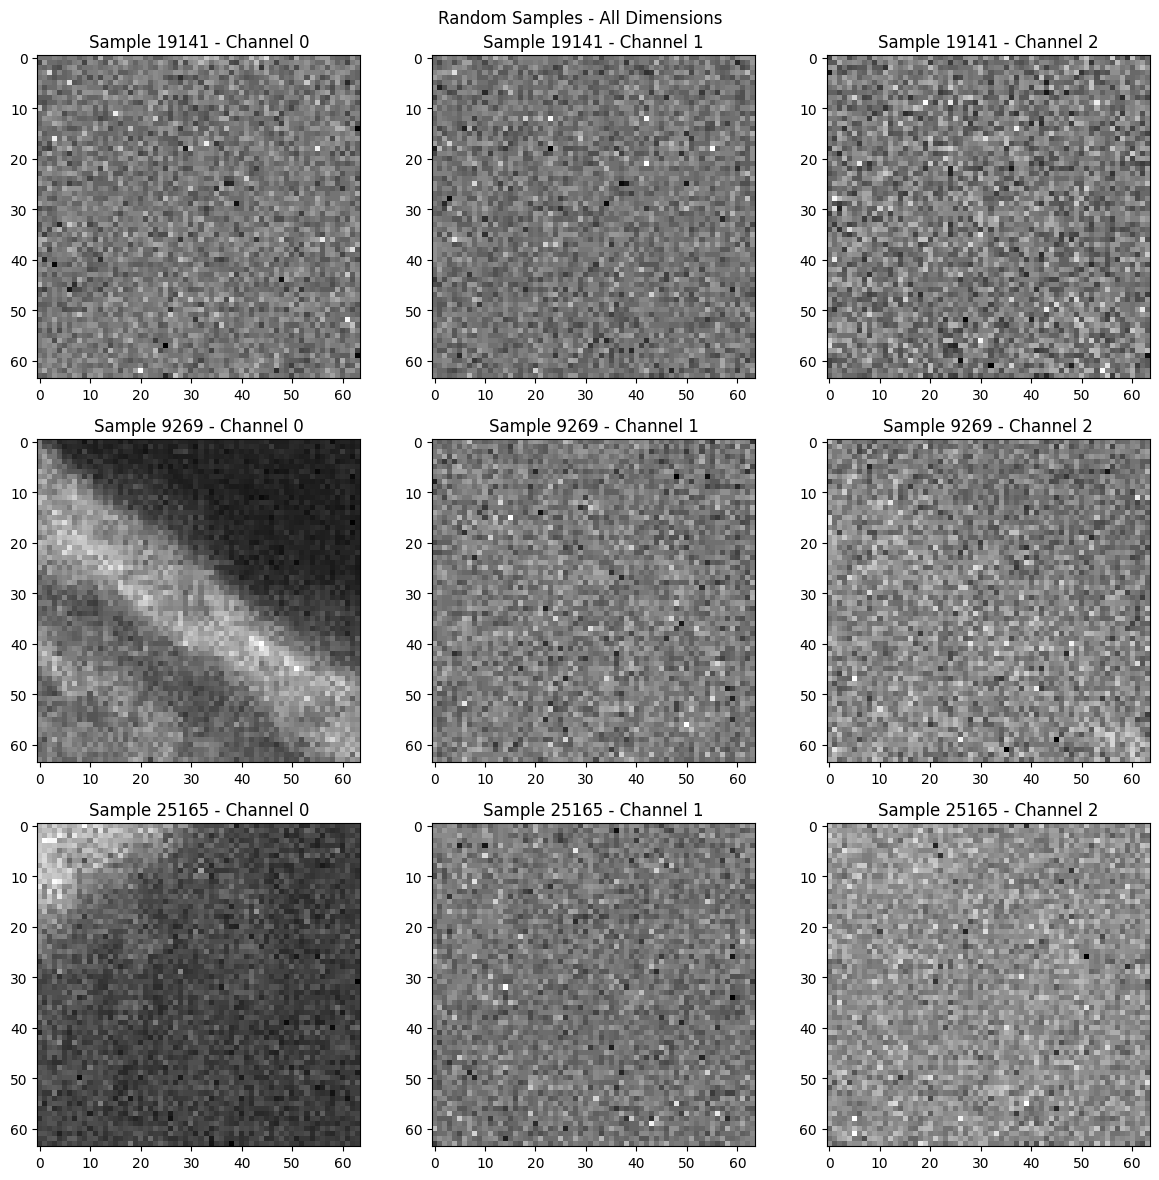

In [ ]:
plot_input_patches(dataset=test_dset, num_channels=3, num_samples=3)

### Create model and load checkpoint

In [ ]:
model = VAEModule(algorithm_config=experiment_config)

[GaussianMixtureNoiseModel] min_sigma: 200.0
[GaussianMixtureNoiseModel] min_sigma: 200.0
[GaussianMixtureNoiseModel] min_sigma: 200.0
[MultiChannelNoiseModel] Nmodels count:3
[GaussianLikelihood] PredLVar:pixelwise LowBLVar:-5.0


#### Set the model to inference mode
(Optional) 
Change the tile size to reduce the appearance of tiling artifacts. The combination of 
# TODO add explanation

In [ ]:
model.model.reset_for_inference(tile_size=[256, 256])

In [ ]:
ckpt = load_checkpoint("checkpoints", best=True)

Loading checkpoint from: 'checkpoints/best.ckpt' - Epoch: 394


In [ ]:
model.load_state_dict(ckpt["state_dict"], strict=True)

<All keys matched successfully>

### Get samples from the model

Here we display a single sample of one image from the test dataset.

In [ ]:
# number of samples to plot
num_samples = 2
stitched_samples = []

# You might need to adjust the batch size depending on the available memory
for i in range(num_samples):
    stitched_samples.append(
        get_single_file_predictions(
            model=model,
            dset=test_dset,
            tile_size=model.model.image_size,
            batch_size=8,
            num_workers=experiment_params["num_workers"],
        )
    )

### Visualize individual samples

Might create tiling artifacts

In [ ]:
plot_individual_samples(stitched_samples)

### Perform evaluation

In [ ]:
# We might need to reset the input size for computing mmse prediction
model.model.reset_for_inference(tile_size=64)

In [14]:
# You might need to adjust the batch size depending on the available memory
stitched_predictions, stitched_stds = get_predictions(
    model=model,
    dset=test_dset,
    batch_size=8,
    num_workers=experiment_params["num_workers"],
    mmse_count=experiment_params["mmse_count"],
    tile_size=model.model.image_size,
)

Predicting tiles:   0%|          | 0/54 [00:01<?, ?it/s]


OutOfMemoryError: CUDA out of memory. Tried to allocate 1024.00 MiB. GPU 0 has a total capacty of 15.81 GiB of which 570.75 MiB is free. Including non-PyTorch memory, this process has 13.88 GiB memory in use. Of the allocated memory 11.01 GiB is allocated by PyTorch, and 1.60 GiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

# Prepare the data for metrics calculation

In [ ]:
# Filename
filename_idx = str(test_dset._fpath).split("/")[-1].split(".")[0]

target = test_dset._data[..., :-1]
predictions = stitched_predictions[filename_idx][..., :-1]

sep_mean = np.transpose(data_stats[0].numpy(), axes=(0, 2, 3, 1))
sep_std = np.transpose(data_stats[1].numpy(), axes=(0, 2, 3, 1))

target_normalized = (target - sep_mean) / sep_std

In [ ]:
pred_unnormalized = []
for i in range(predictions.shape[-1]):
    if sep_std.shape[-1] == 1:
        temp_pred_unnorm = predictions[...,i] * sep_std[...,0] + sep_mean[...,0]
    else:
        temp_pred_unnorm = predictions[...,i] * sep_std[...,i] + sep_mean[...,i]
    pred_unnormalized.append(temp_pred_unnorm)

In [ ]:
# One random target vs predicted image (patch of shape [sz x sz])
ncols = target.shape[-1]
_, ax = plt.subplots(figsize=(ncols * 5, 3 * 5), nrows=3, ncols=2)
img_idx = 10
sz = 800
hs = np.random.randint(target.shape[1] - sz)
ws = np.random.randint(target.shape[2] - sz)
for i in range(ncols):
    ax[i, 0].set_title(f"Target Channel {i+1} for {filename_idx}")
    ax[i, 0].imshow(target[0, hs : hs + sz, ws : ws + sz, i])
    ax[i, 1].set_title(f"Predicted Channel {i+1} for {filename_idx}")
    ax[i, 1].imshow(predictions[0, hs : hs + sz, ws : ws + sz, i])

plt.tight_layout()
plt.subplots_adjust(wspace=0.1, hspace=0.1)

In [ ]:
nrows = predictions.shape[-1]
img_sz = 3
_, ax = plt.subplots(figsize=(4 * img_sz, nrows * img_sz), ncols=4, nrows=nrows)
idx = np.random.randint(len(predictions))
print(idx)
for ch_id in range(nrows):
    ax[ch_id, 0].set_title(f"Target Channel {ch_id+1}")
    ax[ch_id, 0].imshow(target_normalized[idx, ..., ch_id], cmap="magma")
    ax[ch_id, 1].set_title(f"Predicted Channel {ch_id+1}")
    ax[ch_id, 1].imshow(predictions[idx, :, :, ch_id], cmap="magma")
    plot_error(
        target_normalized[idx, ..., ch_id],
        predictions[idx, :, :, ch_id],
        cmap=mpl.cm.coolwarm,
        ax=ax[ch_id, 2],
        max_val=None,
    )

    cropsz = 256
    h_s = np.random.randint(0, target_normalized.shape[1] - cropsz)
    h_e = h_s + cropsz
    w_s = np.random.randint(0, target_normalized.shape[2] - cropsz)
    w_e = w_s + cropsz

    plot_error(
        target_normalized[idx, h_s:h_e, w_s:w_e, ch_id],
        predictions[idx, h_s:h_e, w_s:w_e, ch_id],
        cmap=mpl.cm.coolwarm,
        ax=ax[ch_id, 3],
        max_val=None,
    )

    # Add rectangle to the region
    rect = patches.Rectangle(
        (w_s, h_s), w_e - w_s, h_e - h_s, linewidth=1, edgecolor="r", facecolor="none"
    )
    ax[ch_id, 2].add_patch(rect)

In [ ]:
rmse_arr = []
psnr_arr = []
rinv_psnr_arr = []
ssim_arr = []
for ch_id in range(predictions.shape[-1]):
    rmse = np.sqrt(
        ((predictions[..., ch_id] - target_normalized[..., ch_id]) ** 2)
        .reshape(len(predictions), -1)
        .mean(axis=1)
    )
    rmse_arr.append(rmse)
    rinv_psnr = avg_range_invariant_psnr(
        target_normalized[..., ch_id].copy(), predictions[..., ch_id].copy()
    )
    ssim_mean, ssim_std = avg_ssim(target[...,ch_id], pred_unnormalized[ch_id])
    rinv_psnr_arr.append(rinv_psnr)
    ssim_arr.append((ssim_mean,ssim_std))

In [ ]:
print("RangeInvPSNR: ", " <--> ".join([str(x) for x in rinv_psnr_arr]))
print("MicroSSIM: ", " <--> ".join([f"{round(x,3)}±{round(y,4)}" for (x, y) in ssim_arr]))

### Save results for calibration

In [ ]:
os.makedirs("predictions", exist_ok=True)
for file in test_dset.dsets:
    # get the filename without the path and extension
    filename = file._fpath.split("/")[-1].split(".")[0]
    tifffile.imwrite(
        f"predictions/prediction_{filename}.tif", stitched_predictions[filename]
    )
    tifffile.imwrite(f"predictions/std_{filename}.tif", stitched_stds[filename])